# The good old battle horse 

In [1]:
print("Hello World!")

Hello World!


## But this is too easy. Detour please.

Firs let's scramble those letters

In [2]:
import numpy as np

def scramble(lstr):
    np.random.shuffle(lstr)

hw = "Hello World"
hw = np.array(list(hw))
scramble(hw)
hw = list(hw)
hw

['o', 'W', 'o', 'l', 'l', ' ', 'r', 'H', 'e', 'l', 'd']

## Define some boilerplate classes, just for fun?

In [3]:

rem = [';','(',')',',',':','.','?','!','=','¿','\'',' ','[',']']

class Sentence(object):
    def __init__(self,sentence):
        self.sentence = sentence
        self.lst_sentence = list(self.sentence)
        self.spaces = self.lst_sentence.count(' ') 
        self.stripped = [letter.lower() for letter in self.lst_sentence if letter not in rem]
        self.occr = let_occr(self.stripped)
        
    
    @classmethod
    def from_occr(cls,occr):
        sentence = []
        for key in occr.keys():
            for i in range(occr[key]):
                sentence.append(key)
        
        return cls("".join(sentence))
            
            
    
    @property
    def sentence(self):
        return self._sentence
    
    @sentence.setter
    def sentence(self,sentence):
        if not isinstance(sentence, str):
            raise ValueError("sentence must be string")
        else:
            self._sentence = sentence

            
class Word(object):
    def __init__(self,word):
        self.word = word
        self.occr = let_occr(list(self.word))
        
        
    def is_in_sentence(self,sent):
        if set(self.occr.keys()).issubset(set(sent.occr.keys())):
            for key in self.occr.keys():
                if self.occr[key] > sent.occr[key]:
                    return False
            return True
        else:
            return False

            
        
def let_occr(lst):
    occr = dict()
    for item in lst:
        occr[item] = 0
    for item in lst:
        occr[item] += 1
    return occr

## now

In [4]:
hw = Sentence("".join(hw)) 


## you will need a file with a wordlist 

In [5]:
fp = 'wordlist.txt' #filepath
with open(fp) as file:
    words = [Word(word.strip('\n')) for word in file]

## filter out the first candidates

In [6]:
candidates = [word for word in words if word.is_in_sentence(hw)]
for c in candidates:
    print(c.word)


he
do
we
or
who
her
how
well
her
world
old
hold
word
door
low
oh
role
whole
red
well
hole
wood
roll
hell
row
hero
lower
whole
hello
roll
hold
owe
re
doll
rod
low


## Second filter

In [7]:
import gc
import copy 

def is_in(occr1,occr2):
    if set(occr1.keys()).issubset(set(occr2.keys())):
        for key in occr1.keys():
            if occr1[key] > occr2[key]:
                return False
        return True
    else:
        return False

class Node:
    def __init__(self, occr, cand, w_lst = None):
        self.childs = []
        self.occr = occr
        self.cand = cand
        self.words = w_lst if w_lst else []
        
    def build(self):
        for word in self.cand:
            if is_in(word.occr, self.occr):
                w_lst = self.words + [ word.word ]
                tmp_occr = {}
                for key in self.occr.keys():
                    tmp_occr[key] = self.occr[key]

                for key in word.occr.keys():
                    tmp_occr[key] -= word.occr[key]
                  
                self.childs.append(Node(tmp_occr,self.cand, w_lst))

        for child in self.childs:
            child.build()
    
    def find_possibles(self,lst):
        flag = False
        if not self.childs:
            for key in self.occr.keys():
                if self.occr[key] != 0:
                    flag = True
            if not flag:
                if not any([set(self.words)==set(w) for w in lst]):
                    lst.append(self.words)
                
        for child in self.childs:  
            child.find_possibles(lst)
        

In [8]:
import time

t = time.time()
tree = Node(hw.occr,candidates)
tree.build()
print(f"Took {time.time()-t} seconds")

Took 0.06331515312194824 seconds


In [9]:
phrases = []
tree.find_possibles(phrases)
phrases

[['we', 'hold', 'roll'],
 ['or', 'well', 'hold'],
 ['her', 'low', 'doll'],
 ['world', 'hello'],
 ['old', 'hell', 'row'],
 ['low', 'hell', 'rod']]

In [10]:
freq = {}
for phrase in phrases:
    for word in phrase:
        freq[word] = 0



In [31]:
import pandas as pd
wfreqdf = pd.read_excel('wordFrequency.xls',sheet_name=None)['1 lemmas']


In [34]:
wfreqdf.loc[wfreqdf['lemma']=='world']

,rank,lemma,PoS,freq,perMil,%caps,%allC,range,disp,blog,...,news,acad,blogPM,webPM,TVMPM,spokPM,ficPM,magPM,newsPM,acadPM
133,134,world,n,732511,737.66,0.18,0.01,208857,0.98,108450,...,88531,95286,872.81,914.11,502.47,719.27,509.94,850.69,727.2,795.44


For those of you that dont know it, there is a power law, i.e. Zipf Law, that defines that the decreasing orderly of frequency of words follows a power relationship with its rank. That is 

$$P_n \approx \frac{1}{n^a}$$

this can be seen in the plot below

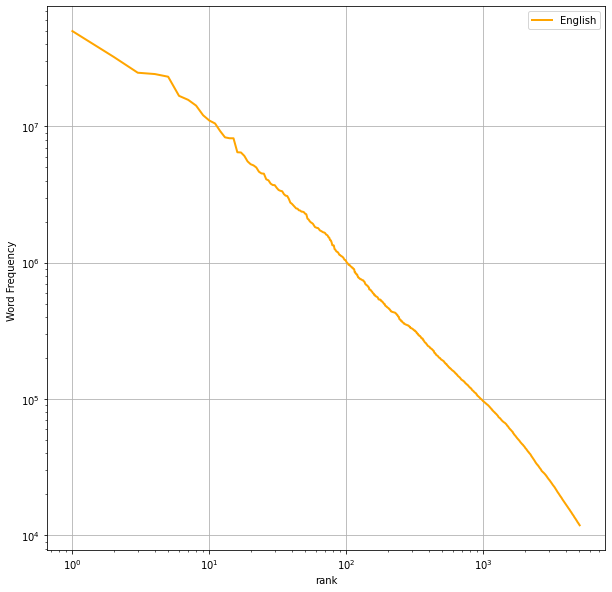

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline 

fig=plt.figure(figsize=(10,10))
plt.grid()
plt.xlabel("rank")
plt.ylabel("Word Frequency ")
plt.xscale('log')
plt.yscale('log')
plt.plot(wfreqdf['rank'],wfreqdf['freq'],color='orange',linewidth=2,label='English')
plt.legend(loc=1)


Now it would be nice to have a way to imply a ranking from a phrase with different words. This way of defining a ranking of phrases has to correctly represent the commonality of phrases from singled out word frequency. The real way of doing this is predicting the next word of a phrase from the past history. In the phrases we reported, there are just unordered list. So our approximation to rank the words will be the geometric mean of the normalized frequencies. 


In [67]:
accum = sum(wfreqdf['freq'])
wfreqdf['freq'] = wfreqdf['freq'].div(accum)

,rank,lemma,PoS,freq,perMil,%caps,%allC,range,disp,blog,...,news,acad,blogPM,webPM,TVMPM,spokPM,ficPM,magPM,newsPM,acadPM
0,1,the,a,0.060272,50385.16,0.11,0.00,482995,0.98,6266654,...,6579270,7440931,50434.35,55169.32,29524.14,45672.67,53310.74,53941.86,54042.73,62116.23
1,2,be,v,0.039024,32622.71,0.03,0.01,481177,0.99,5594001,...,4102481,3689062,45020.81,41409.63,62695.87,55701.50,37289.40,33259.44,33698.16,30795.96
2,3,and,c,0.029848,24952.20,0.09,0.00,478670,0.98,3205178,...,2993061,3627686,25795.44,26849.01,14249.23,26275.16,25860.15,26177.63,24585.28,30283.60
3,4,a,a,0.029183,24395.69,0.04,0.04,478204,0.99,3098338,...,3299770,2602697,24935.58,24747.22,20690.47,23374.72,25107.33,27541.93,27104.62,21727.08
4,5,of,i,0.027898,23321.89,0.01,0.00,477933,0.97,2897295,...,2867922,4500485,23317.58,26588.36,10918.77,20157.43,19270.82,25796.39,23557.38,37569.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5045,5046,keyboard,n,0.000014,11.97,0.05,0.00,5580,0.92,2464,...,805,1380,19.83,19.25,2.45,3.74,10.75,21.43,6.61,11.52
5046,5047,persist,v,0.000014,11.96,0.01,0.00,9554,0.94,1181,...,1198,3860,9.50,12.60,1.33,4.29,11.00,15.92,9.84,32.22
5047,5048,wheat,n,0.000014,11.96,0.15,0.01,5843,0.94,1287,...,1952,1755,10.36,11.27,4.75,5.07,10.94,22.93,16.03,14.65
5048,5049,predator,n,0.000014,11.96,0.14,0.01,6042,0.94,1166,...,1242,1760,9.38,8.85,8.13,10.54,8.40,25.42,10.20,14.69


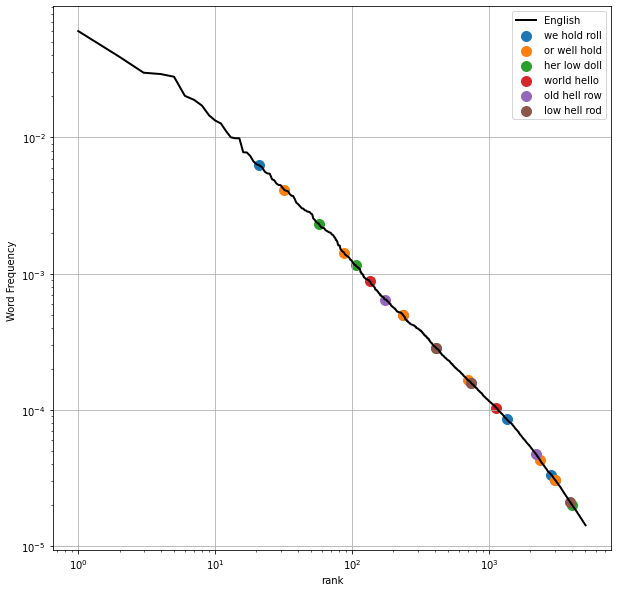

In [68]:
fig=plt.figure(figsize=(10,10))
plt.grid()
plt.xlabel("rank")
plt.ylabel("Word Frequency ")
plt.xscale('log')
plt.yscale('log')
plt.plot(wfreqdf['rank'],wfreqdf['freq'],color='k',linewidth=2,label='English')

for phrase in phrases:
    tmp = wfreqdf.loc[wfreqdf['lemma'].isin(phrase)]
    plt.scatter(tmp['rank'],tmp['freq'],s=100,label=" ".join(phrase))

plt.legend(loc=1)

In [87]:
freqs = [[wfreqdf.loc[wfreqdf['lemma'] == w]['freq'].values[0] for w in phrase] for phrase in phrases]

import math
geomean = [ (math.prod(fr))**(1/len(fr)) for fr in freqs]
arithmean = [ sum(fr)/len(fr) for fr in freqs]

In [90]:
phrases

[['we', 'hold', 'roll'],
 ['or', 'well', 'hold'],
 ['her', 'low', 'doll'],
 ['world', 'hello'],
 ['old', 'hell', 'row'],
 ['low', 'hell', 'rod']]

In [88]:
geomean

[0.0006435681075765075,
 0.0014329247805069665,
 0.00023736641080875887,
 0.00030342595016252366,
 0.00016970705024644295,
 9.838507785535056e-05]

In [89]:
arithmean

[0.002275001537582372,
 0.0020170517355657387,
 0.0008773398789851814,
 0.0004933689145925063,
 0.00028442141965294063,
 0.00015491548012624705]

There is no sensible way of comparing n-grams with different n, since the probability of a long phrase occurring is less than a short one, this is even more evident when the shorter phrase is a subset of the longer one. Therefore, we must find another path, maybe not that detourly.

We know for a fact that "hello world" is a phrase with two words. We can filter out all the phrases that doesnt match this condition. The answer is just one. 

In [100]:
filtered = filter(lambda x: len(x) == 2, phrases)

for item in filtered:
    print(item)

['world', 'hello']


Now we must define the order of the words in the phrase. The direct way of evaluating this is calculating from 2-gram (bigram) datasets their frequency of ocurrence. This would be denoted as 

$$P("world \ hello") = \frac{C("world \ hello")}{amount \ of \ bigrams}$$
in a same manner

$$P("hello \ world") = \frac{C("hello \ world")}{amount \ of \ bigrams} $$

In order to achieve this I will use the N-gram viewer from google, the url down below is obviously hardcoded.

In [126]:
import requests

url = 'https://books.google.com/ngrams/json?content=hello+world%2Cworld+hello&year_start=1800&year_end=2019&corpus=26&smoothing=3&case_insensitive=false'
req = requests.get(url)

In [133]:
json_lst = req.json()

In [135]:
bigrams = [ j for j in json_lst if "(All)" in j['ngram']]

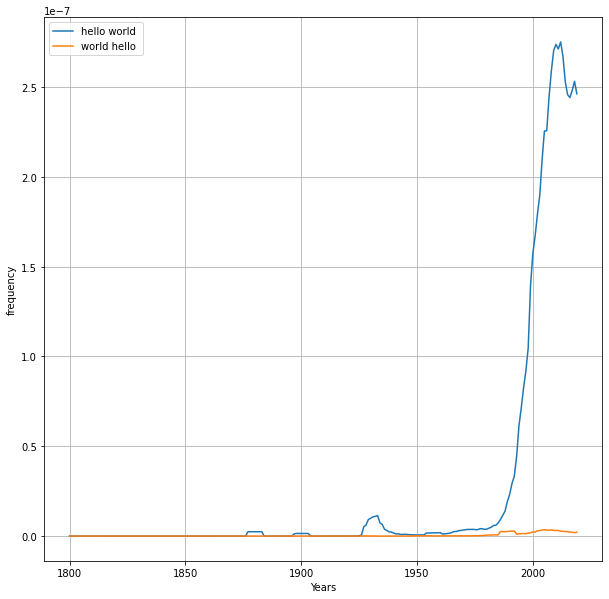

In [145]:
years = [1800+i for i in range(len(bigrams[0]['timeseries']))]

plt.figure(figsize=(10,10))
plt.grid()
plt.xlabel("Years")
plt.ylabel("frequency")
for bi in bigrams:
    plt.plot(years,bi['timeseries'],label = bi['ngram'].replace("(All)",""))
plt.legend(loc=2)

Therefore we will print out the most common phrase in terms of the year, for that we define a simple function.

In [154]:
def find_max_year(year,data,offset=1800):
    tmp = [(d['timeseries'][year-offset],d['ngram']) for d in data]
    fmax = 0
    idx = 0
    for i in range(len(tmp)):
        if tmp[i][0] > fmax:
            fmax=tmp[i][0]
            idx = i
    return tmp[idx][1].replace("(All)","")
        

In [157]:
hw = find_max_year(2019,bigrams)
hw

'hello world '